In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Загрузка данных

In [15]:
data = pd.read_csv('data/hotel_data.csv', sep=';')

In [16]:
data.head()

,Hotel name,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
0,Bonanova Park,7.7,2.0,7.0,5.0,16.0,0,63
1,Travelodge Barcelona Poblenou,7.9,1.0,0.5,2.0,15.0,0,83
2,Senator Barcelona Spa Hotel,7.8,4.0,5.0,3.0,21.0,1,91
3,Hotel Medicis,7.9,2.0,2.0,1.0,10.0,0,87
4,Paral-lel,8.4,2.0,0.5,1.0,19.0,0,102


## 2. Построение корреляционной матрицы

In [17]:
data.corr()

,Rating,Stars,Distance to the sea,Distance to the downtown,Room area,Swimming pool,Price
Rating,1.000000,0.186146,-0.021557,-0.128974,0.194202,0.202255,0.405103
Stars,0.186146,1.000000,0.161972,0.177887,0.478342,0.297641,0.593391
Distance to the sea,-0.021557,0.161972,1.000000,0.333458,0.072766,0.054242,0.004539
Distance to the downtown,-0.128974,0.177887,0.333458,1.000000,0.146861,0.158823,-0.109614
Room area,0.194202,0.478342,0.072766,0.146861,1.000000,0.265249,0.364820
Swimming pool,0.202255,0.297641,0.054242,0.158823,0.265249,1.000000,0.253810
Price,0.405103,0.593391,0.004539,-0.109614,0.364820,0.253810,1.000000


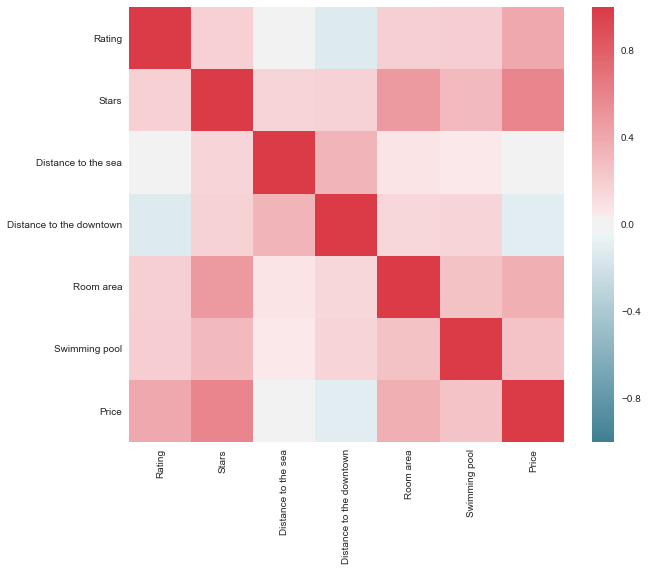

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)